Import dependencies and pollen data

In [1]:
import h5py
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, losses, optimizers, metrics
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

Let's check that the GPU is detected

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We import all the data, already prepared

In [3]:
f = h5py.File('proc_data.h5', 'r')

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = np.array(f['X_train']), np.array(f['Y_train']), np.array(f['X_dev']), np.array(f['Y_dev']), f['X_test'], f['Y_test']

m_train = X_train.shape[0]
window_size = X_train.shape[1] + 1
n = X_train.shape[2]

print(X_train.shape)

(67126, 6, 12)


Finally, we can start building our model!

In [4]:
X_in = Input(shape=(window_size - 1, n))
X = LSTM(20, dropout=0)(X_in)
X_out = Dense(units=1)(X)

model = Model(inputs=X_in, outputs=X_out)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 12)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                2640      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________


In [6]:
opt = Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.99, epsilon=1e-7, clipnorm=10)
model.compile(loss='mse', optimizer=opt)

In [14]:
fitting = model.fit(X_train, Y_train, batch_size=512, epochs = 10, validation_data=(X_dev, Y_dev))

Epoch 1/10
132/132 [==============================] - 3s 20ms/step - loss: 1109.6948 - val_loss: 1138.0991
Epoch 2/10
132/132 [==============================] - 1s 8ms/step - loss: 1106.2493 - val_loss: 1134.9130
Epoch 3/10
132/132 [==============================] - 1s 8ms/step - loss: 1106.0330 - val_loss: 1136.4485
Epoch 4/10
132/132 [==============================] - 1s 8ms/step - loss: 1099.5662 - val_loss: 1130.2775
Epoch 5/10
132/132 [==============================] - 1s 8ms/step - loss: 1103.8628 - val_loss: 1133.8971
Epoch 6/10
132/132 [==============================] - 1s 8ms/step - loss: 1101.3269 - val_loss: 1132.8027
Epoch 7/10
132/132 [==============================] - 1s 8ms/step - loss: 1099.9204 - val_loss: 1133.9222
Epoch 8/10
132/132 [==============================] - 1s 8ms/step - loss: 1106.3221 - val_loss: 1132.9613
Epoch 9/10
132/132 [==============================] - 1s 8ms/step - loss: 1101.5378 - val_loss: 1133.4933
Epoch 10/10
132/132 [========================

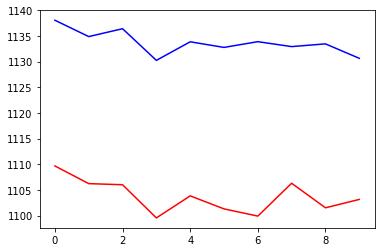

In [15]:
plt.plot(np.array(fitting.history['loss']), color='r')
plt.plot(np.array(fitting.history['val_loss']), color='b')
plt.show()

- v1.0 val_loss = 3.175 after 400 epochs
- v1.1 val_loss = 1.797 after 400 epochs
    - Added precipitation data
- v1.2 val_loss = 0.716 after 400 epochs
    - Added a log kernel to pollen data

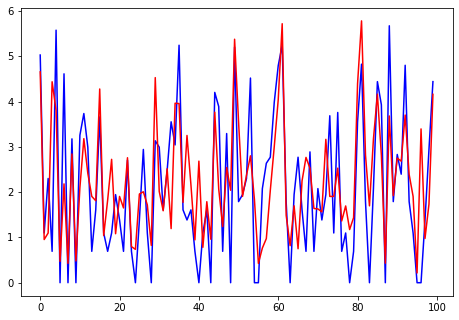

In [17]:
pollen_mean, pollen_std = f['parameters']

start_pred = 600
end_pred = 700

Y_true = Y_dev[start_pred:end_pred, 0]*pollen_std + pollen_mean
Y_pred = model(X_dev)[start_pred:end_pred, 0]*pollen_std + pollen_mean

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.plot(Y_true, color='b')
ax.plot(Y_pred, color='r')

plt.show()

Here we plot the data directly as it is, with the log kernel, and in the next cell reverted back to the original values. I plotted it in the original distribution because I suspect that it is what I will use when I classify the predictions into a few classes or 'levels' of pollen in air. This is because, as I have said earlier, what we need a lot of sensitivity to large changes in pollen levels, while changes in the low-end values are irrelevant to the app's intent.

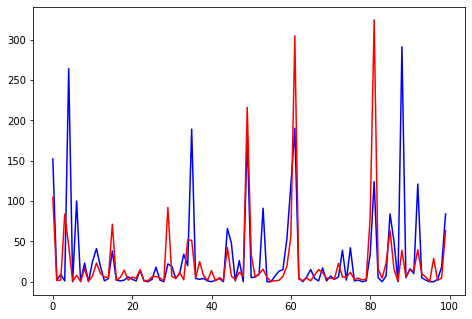

In [18]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.plot(np.exp(Y_true) - 1, color='b')
ax.plot(np.exp(Y_pred) - 1, color='r')

plt.show()

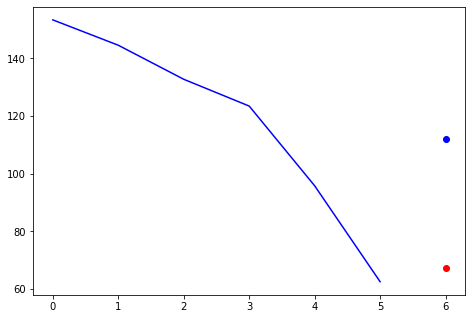

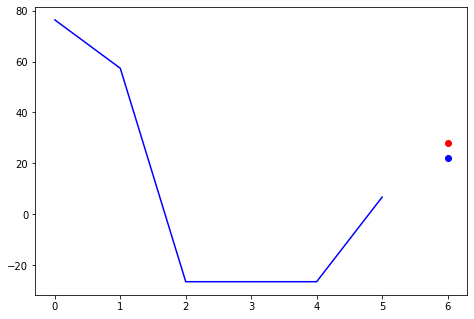

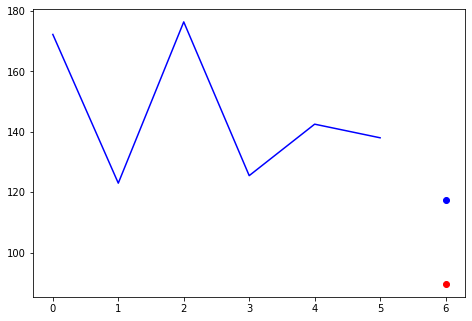

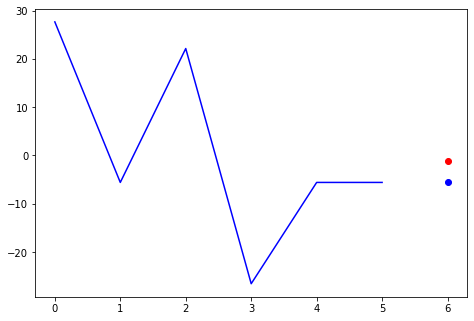

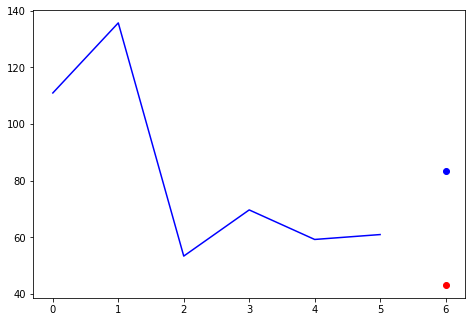

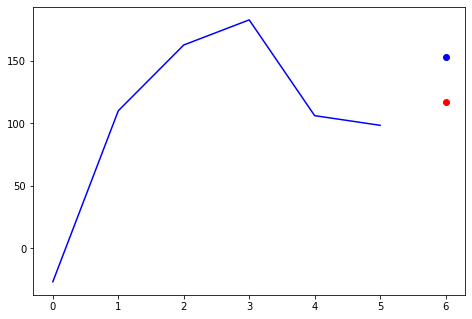

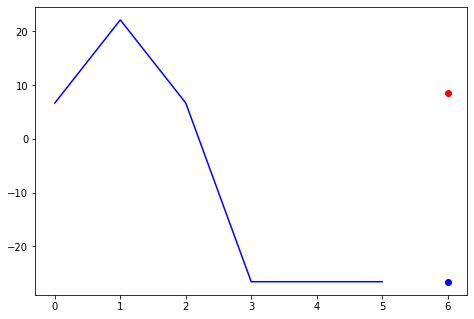

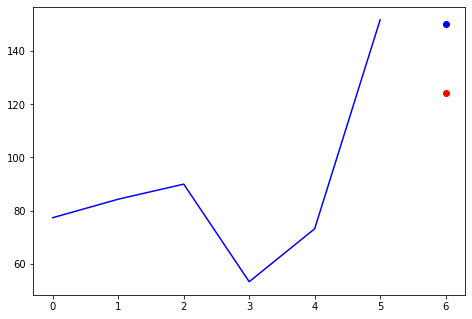

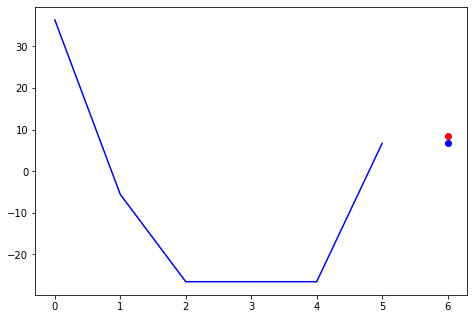

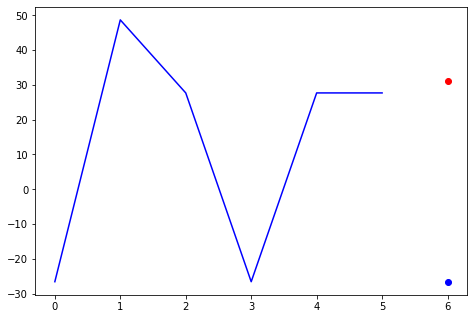

In [30]:
start_windows = 150
end_windows = 160

X_pred = X_dev[start_windows:end_windows]
Y_pred = model(X_pred)
Y_real = Y_dev[start_windows:end_windows]

for i in range(end_windows - start_windows):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.plot(range(window_size - 1), X_pred[i, : , 0] , color = 'b')
    ax.scatter(window_size - 1, Y_real[i], color = 'b')
    ax.scatter(window_size - 1, Y_pred[i], color='r')
    
    fig.show()
    
#plt.show()